In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

In [24]:
fight_df = pd.read_csv(r"C:\Users\vtewa\OneDrive\Desktop\data.csv")

In [19]:
def prob_i_beats_j(rating_i, rating_j):
    return 1 / (1 + 10**((rating_j - rating_i) / 400))

Text(0, 0.5, 'Pr(i beats j)')

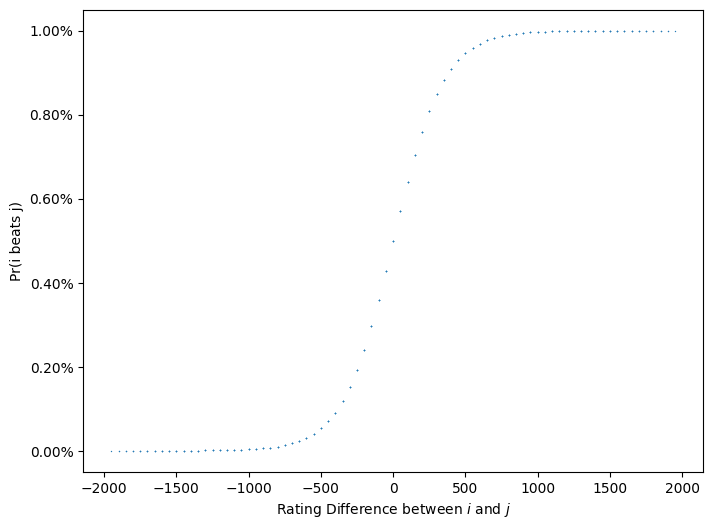

In [22]:
rating_range = np.arange(500, 2500, 50)
probs = [prob_i_beats_j(ri, rj) for ri in rating_range for rj in rating_range]
rating_diff = [ri - rj for ri in rating_range for rj in rating_range]
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sns.scatterplot(x=rating_diff, y=probs, ax=ax, s=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel("Rating Difference between $i$ and $j$")
ax.set_ylabel("Pr(i beats j)")

[Text(0, 0, '500'), Text(0, 20, '1500')]

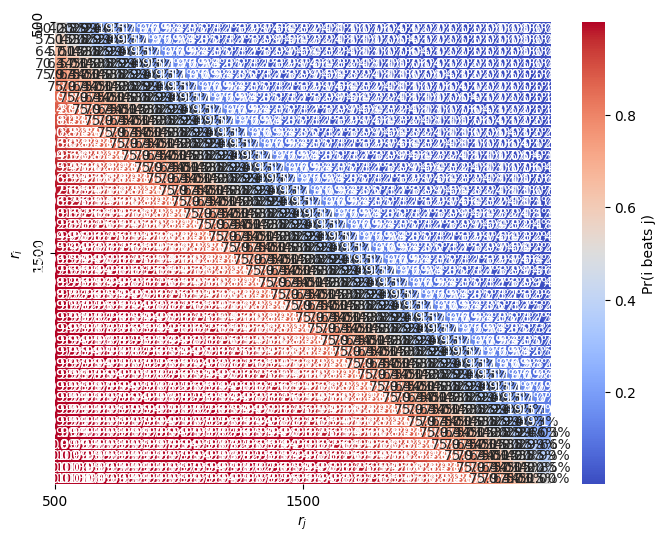

In [21]:
# rating_range = np.arange(500, 2500, 50)
# probs = [prob_i_beats_j(ri, rj) for ri in rating_range for rj in rating_range]
# rating_diff = [ri - rj for ri in rating_range for rj in rating_range]
# fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
# sns.scatterplot(rating_diff, probs, ax=ax, s=1)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_xlabel("Rating Difference between $i$ and $j$")
# ax.set_ylabel("Pr(i beats j)")

rating_range = np.arange(500, 2500, 50)
probs = np.array([prob_i_beats_j(ri, rj) for ri in rating_range for rj in rating_range])
probs = probs.reshape(len(rating_range), len(rating_range))
rating_diff = np.array([ri - rj for ri in rating_range for rj in rating_range]).reshape(len(rating_range), len(rating_range))

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(probs, annot=True, fmt=".2%", ax=ax, cmap="coolwarm", cbar_kws={'label': 'Pr(i beats j)'})
ax.set_xlabel("$r_j$")
ax.set_ylabel("$r_i$")
ax.set_xticks(np.arange(0, len(rating_range), 20))
ax.set_xticklabels(rating_range[::20])
ax.set_yticks(np.arange(0, len(rating_range), 20))
ax.set_yticklabels(rating_range[::20])


In [13]:
def get_win_method_weight(x: str) -> float:
    if "Decision" in x:
            return 3.
    elif "KO" in x:
        return 5.
    elif "Submission" in x:
        return 5.
    else:
        return 0.

In [14]:
class Elo:
    def __init__(self, k: int):
        self.rating_dict = {}
        self.k = k
def __getitem__(self, player: str) -> float:
        return self.rating_dict[player]

def __setitem__(self, player: str, data: float) -> None:
        self.rating_dict[player] = data

def get_margin_factor(self, score: float) -> float:
        return np.log2(score + 1)

def get_inflation_factor(self, r_win: float, r_lose: float) -> float:
        return 1 / (1 - ((r_lose - r_win) / 2200))

def add_player(self, name: str, rating: float = 1500.):
        self.rating_dict[name] = rating

def update_ratings(self, winner: str, loser: str, score: float) -> None:
        
        expected_result = self.get_expect_result(
            self.rating_dict[winner], self.rating_dict[loser]
        )
        margin_factor = self.get_margin_factor(score)
        inflation_factor = self.get_inflation_factor(
            self.rating_dict[winner], self.rating_dict[loser]
        )
        self.rating_dict[winner] = self.rating_dict[winner] + self.k * margin_factor * inflation_factor * (1 - expected_result)
        self.rating_dict[loser] = self.rating_dict[loser] + self.k * margin_factor * inflation_factor * (-1 + expected_result)

def get_expect_result(self, p1: float, p2: float) -> float:
        exp = (p2 - p1) / 400.0
        return 1 / ((10.0 ** (exp)) + 1)

In [15]:
# def calc_elo_rank(df: pd.DataFrame) -> pd.DataFrame:
#     elo_scorer = Elo(k = 20)
#     fighter_set = set(df['winner_slog'].unique().tolist() + df['loser_slog'].unique().tolist())
#     for fighter in fighter_set:
#         elo_scorer.add_player(fighter)
#     elo_f1 = np.zeros((len(df,)))
#     elo_f2 = np.zeros((len(df,)))
#     for rowidx, fs_row in tqdm(enumerate(df.itertuples())):
#         fighter = fs_row.winner_slog
#         opponent = fs_row.loser_slog
#         score = fs_row.win_method_score
#     elo_f1[rowidx] = elo_scorer[fighter]
#     elo_f2[rowidx] = elo_scorer[opponent]=
#     elo_scorer.update_ratings(fighter, opponent, score)
#     df.loc[:, 'elo_f1'] = elo_f1
#     df.loc[:, 'elo_f2'] = elo_f2
    
#     return df

In [30]:
def calc_elo_rank(df: pd.DataFrame) -> pd.DataFrame:
    elo_scorer = Elo(k = 20)
    fighter_set = set(df['R_fighter'].unique().tolist() + df['B_fighter'].unique().tolist())
    for fighter in fighter_set:
        elo_scorer.add_player(fighter)
    elo_R = np.zeros((len(df,)))
    elo_B = np.zeros((len(df,)))
    for rowidx, row in tqdm(enumerate(df.itertuples())):
        winner = row.Winner
        winner_elo = elo_scorer[row.R_fighter if row.Winner == 'Red' else row.B_fighter]
        loser_elo = elo_scorer[row.B_fighter if row.Winner == 'Red' else row.R_fighter]
        score = 1 if row.Winner == 'Red' else 0
        elo_scorer.update_ratings(winner, score, loser_elo)
        elo_R[rowidx] = elo_scorer[row.R_fighter]
        elo_B[rowidx] = elo_scorer[row.B_fighter]
    df.loc[:, 'elo_R'] = elo_R
    df.loc[:, 'elo_B'] = elo_B
    
    return df

In [32]:
#max_ranking = (pd.concat([
#        fight_df[['winner', 'winner_slog', 'weightclass', 'elo_f1']]
#        .rename(
#            dict(winner='fighter', winner_slog='fighter_slog', elo_f1='elo'),
#            axis=1),
#        fight_df[['loser', 'loser_slog', 'weightclass', 'elo_f2']]
#        .rename(
#            dict(loser='fighter', loser_slog='fighter_slog', elo_f2='elo'),
#            axis=1)
#    ])
#    .groupby(
#        ['fighter', 'fighter_slog', 'weightclass'],
#        as_index=False)['elo']
#    .max()
#)

# max_ranking = fight_df[['winner', 'winner_slog', 'weightclass', 'elo_f1']].rename(
# {'winner': 'fighter', 'winner_slog': 'fighter_slog', 'elo_f1': 'elo'},
# axis=1)

# max_ranking = max_ranking.append(
# fight_df[['loser', 'loser_slog', 'weightclass', 'elo_f2']].rename(
# {'loser': 'fighter', 'loser_slog': 'fighter_slog', 'elo_f2': 'elo'},
# axis=1), ignore_index=True
# )

# max_ranking = max_ranking.groupby(
# ['fighter', 'fighter_slog', 'weightclass'],
# as_index=False)['elo'].max()

max_ranking = (pd.concat([
fight_df[['winner', 'winner_slog', 'weightclass', 'elo_f1']]
.rename(
dict(winner='fighter', winner_slog='fighter_slog', elo_f1='elo'),
axis=1),
fight_df[['loser', 'loser_slog', 'weightclass', 'elo_f2']]
.rename(
dict(loser='fighter', loser_slog='fighter_slog', elo_f2='elo'),
axis=1)
])
.groupby(
['fighter', 'fighter_slog', 'weightclass'],
as_index=False)['elo']
.max()
)


KeyError: "None of [Index(['winner', 'winner_slog', 'weightclass', 'elo_f1'], dtype='object')] are in the [columns]"